# ispace 週足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

code = '9348'
symbol = '%s.T' % code
ticker = yf.Ticker(symbol)

df = ticker.history(period='5y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-10 00:00:00+09:00,1000.0,1501.0,950.0,1501.0,29053600,0.0,0.0
2023-04-17 00:00:00+09:00,1901.0,2373.0,1800.0,1804.0,74281100,0.0,0.0
2023-04-24 00:00:00+09:00,1964.0,2170.0,1001.0,1017.0,47943300,0.0,0.0
2023-05-01 00:00:00+09:00,1025.0,1193.0,1005.0,1010.0,16424300,0.0,0.0
2023-05-08 00:00:00+09:00,1022.0,1027.0,793.0,856.0,12355400,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-07 00:00:00+09:00,561.0,723.0,555.0,721.0,15384800,0.0,0.0
2025-04-14 00:00:00+09:00,722.0,883.0,702.0,862.0,18314500,0.0,0.0
2025-04-21 00:00:00+09:00,877.0,928.0,796.0,913.0,24261100,0.0,0.0


## 週足チャートとパラボリック SAR

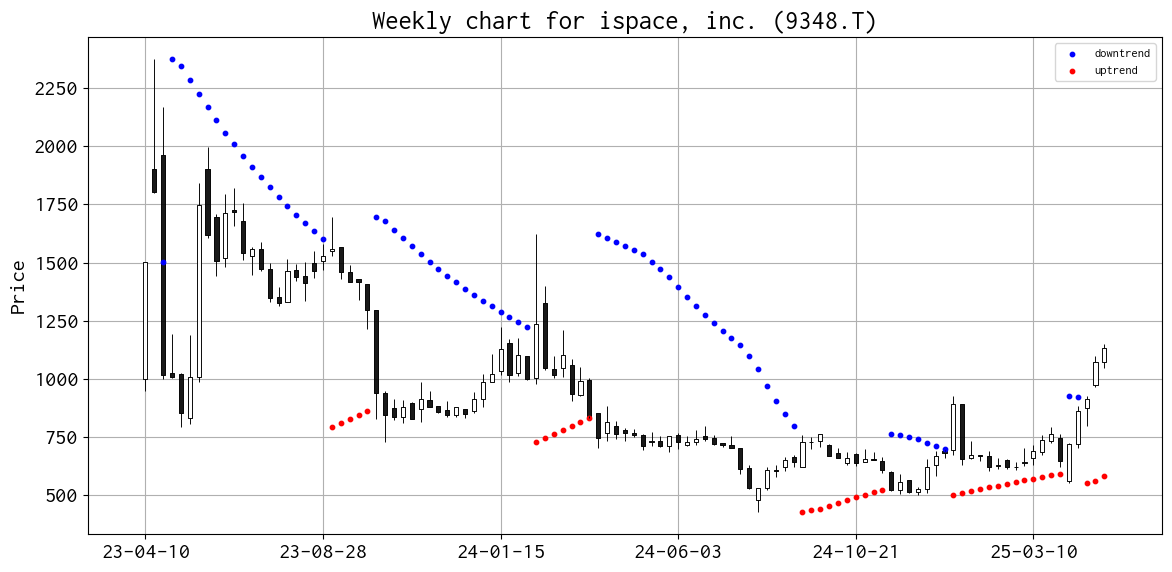

In [3]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=False,
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Weekly chart for %s (%s)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Weekly chart for %s' % symbol)

ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('weekly_chart_%s.png' % m.group(1))
else:
    plt.savefig('weekly_chart_%s.png' % symbol)

plt.savefig('reference/report_weekly_chart_parabolic_sar_%s.png' % code)
plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-04-28 00:00:00+09:00    1074.0
2025-05-05 00:00:00+09:00    1135.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-04-28 00:00:00+09:00     NaN
2025-05-05 00:00:00+09:00    61.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-04-28 00:00:00+09:00    843.6
2025-05-05 00:00:00+09:00    941.0
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-04-28 00:00:00+09:00    685.88
2025-05-05 00:00:00+09:00    707.00
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-04-28 00:00:00+09:00    761.720000
2025-05-05 00:00:00+09:00    765.413333
Name: Close, dtype: float64